## Cotton farms in Moree

Moree is a town in northern New South Wales, Australia. It is located on the banks of the Mehi River, in the centre of the Jim plains. Its name comes from an Aboriginal word for “rising sun”, “long spring”, or “water hole".

Moree is a major agricultural centre, noted for its part in the Australian cotton-growing industry which was established there in the early 1960s. The town is renowned by its healing artesian hot spring baths. At the 2016 census, the town of Moree had a population of 7,383. 

<img src="data/Moree_Satellite.png" alt="drawing" width="400" align="left"/>

Australia’s cotton growing season lasts approximately six months, starting in September/October (planting) and ending in March/April (picking). Irrigation water availability is a limiting factor in cotton production. Water-use efficiency has increased by approximately 240 percent since the 1970’s and Australian cotton growers are now recognised as the most water-use efficient in the world and three times more efficient than the global average. [Source: agriculture.gov.au](http://www.agriculture.gov.au)

The demand for cotton worldwide has been steadily increasing in recent years. The good quality of Australian cotton is recognised worldwide and constitutes an attractive product for farmers.

<figure>
  <img src="data/cotton_demand.jpg" alt="drawing" width="400" align="left"/>
  <figcaption>Evolution of worldwide cotton demand since year 2000. (Source: Abares)</figcaption>
</figure>

### Your task:

After many years working in an office, you have decided to become a cotton farmer. You are looking for properties for sale near Moree but you have heard at the local pub, about the big differences in productivity between lands. 

There are a couple of properties that fit your budget and you would like to find out which one has historically performed better in the past years. You cannot trust much the numbers that the previous owners are giving to you and want to find a more independent method to inform your decision. Luckily, in your previous job you had to use the DEA for very different purposes and you decide to give it a go.

You know about the Fractional Cover product and you decide to use it for comparing the performance for these two properties, over the last growing season.

Fractional Cover represents the proportion of the land surface that is bare (BS), covered by photosynthetic vegetation (PV), or non-photosynthetic vegetation (NPV). The green (PV) fraction includes leaves and grass, the non-photosynthetic fraction (NPV) includes branches, dry grass and dead leaf litter, and the bare soil (BS) fraction includes bare soil or rock. You expect to see an increase in the bare soil fraction over the past years.

### Load packages

You start by loading the usual Python libraries to start working on this project.

In [3]:
%matplotlib inline

import datacube

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr

### Setting up

We create the DEA object and list the products that are currently available on the DEA containing the string `fc` which is the code that indicates Fractional Cover.

In [4]:
dc = datacube.Datacube(app='dc-FC')
products = dc.list_products()
display_columns = ['name', 'description']
display_rows = [1]
dc_products = products[display_columns]
dc_products[dc_products['name'].str.contains("fc")]

,name,description
id,,
10,fc_percentile_albers_annual,"Landsat Fractional Cover percentile 25 metre, ..."
11,fc_percentile_albers_seasonal,"Landsat Fractional Cover percentile 25 metre, ..."
4,ls5_fc_albers,"Landsat 5 Fractional Cover 25 metre, 100km til..."
41,ls7_fc_albers,"Landsat 7 Fractional Cover 25 metre, 100km til..."
5,ls8_fc_albers,"Landsat 8 Fractional Cover 25 metre, 100km til..."


### Property A

You start by putting together Fractional Cover for Landsat 8 data for the first property.

In [5]:
dc_moree = datacube.Datacube()

query = {'lat': (-29.34, -29.42),
         'lon': (149.78, 149.91),
         'time':('2018-06-01', '2019-06-01')}

fc_propA = dc_moree.load(product='ls8_fc_albers', **query)

# Cloud filtering functionality for FC is currently being developed so we manually filter cloudly images
fc_propA = fc_propA.isel(time=[0,2,4,5,6,7,9,10,11,12,13,16,19,20,22])

fc_propA

<xarray.Dataset>
Dimensions:      (time: 15, x: 545, y: 426)
Coordinates:
  * time         (time) datetime64[ns] 2018-06-10T23:53:43 ... 2019-05-28T23:...
  * y            (y) float64 -3.308e+06 -3.308e+06 ... -3.318e+06 -3.319e+06
  * x            (x) float64 1.7e+06 1.7e+06 1.7e+06 ... 1.713e+06 1.713e+06
    spatial_ref  int32 3577
Data variables:
    BS           (time, y, x) int16 69 69 68 67 67 68 67 ... 46 51 54 58 68 51
    PV           (time, y, x) int16 5 5 4 4 4 5 5 5 5 5 ... 13 1 2 0 0 2 5 5 5
    NPV          (time, y, x) int16 25 25 26 27 27 26 27 ... 53 48 43 35 26 42
    UE           (time, y, x) int16 11 11 11 11 11 11 11 ... 19 20 18 16 15 16
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Visualising the 3 fractions together

You have 23 clean images of the area around the first property for the last year. You create a function to plot the 3 fraction plus the Unmixing Error (UE) variable which gives an indication about the uncertainty in the computation of the fractions.

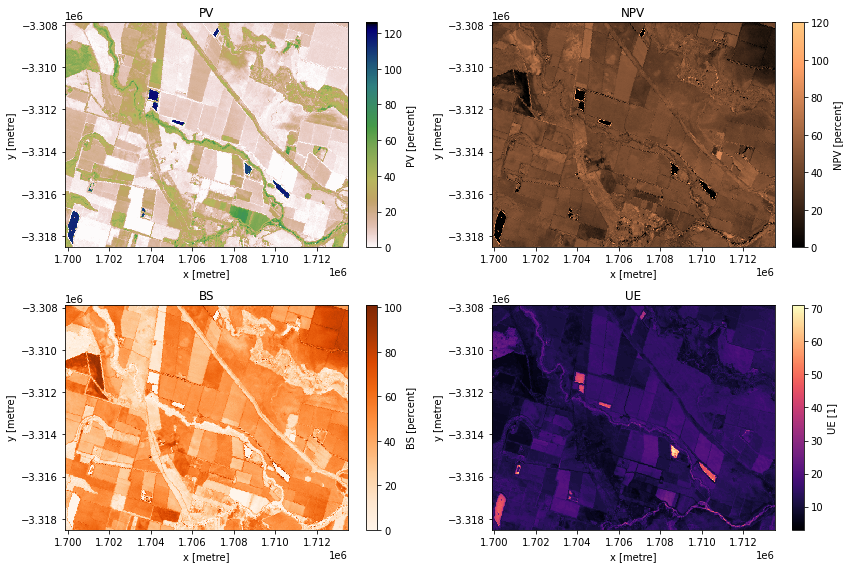

In [6]:
import matplotlib.gridspec as gridspec

def plot_fractions(ds, scene):
    #set up our images on a grid using gridspec
    plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

    ax1=plt.subplot(gs[0,0])
    ds.PV.isel(time=scene).plot(cmap='gist_earth_r')
    ax1.set_title('PV')

    ax2=plt.subplot(gs[1,0])
    ds.BS.isel(time=scene).plot(cmap='Oranges')
    ax2.set_title('BS')

    ax3=plt.subplot(gs[0,1])
    ds.NPV.isel(time=scene).plot(cmap='copper')
    ax3.set_title('NPV')

    ax4=plt.subplot(gs[1,1])
    ds.UE.isel(time=scene).plot(cmap='magma')
    ax4.set_title('UE')

    plt.tight_layout()
    plt.show()
    
plot_fractions(fc_propA, 0)

### Detecting cropping lands

Land dedicated to cropping goes through a series of changes during the season. At the beginning of the season, the land is plowed and presents no vegetation and, at the middle of the season, the fields are green. Later in the growing season, depending on the type of crop, fields start yellowing until the harvest time.

The changes in land dedicated to crop are usually larger than in the surrounding lands. The PV fraction in the fractional cover product might become handy for identifying the parts of land dedicated to grow crops. If we consider the temporal evolution of an individual pixels in a PV image, we'll observe that the variability is usually larger for crop farms that for other types of land.

Making use of the variability through time, you are going to identify the cropping areas around Moree.

In [7]:
land_std = fc_propA.PV.std(dim='time')
print("Shape:",land_std.shape)
print("Min: {:02f}, Max: {:02f}, Mean {:02f}".format(np.nanmin(land_std), np.nanmax(land_std), np.nanmean(land_std)))### Now we load and look at some data

Shape: (426, 545)
Min: 0.748331, Max: 53.426169, Mean 10.139127


### Masking croplands

Now you look at the maximum and minimum values and determine a threshold value to create a mask for leaving out all non-cropping lands. After some try and error, 20 seems to give reasonable results.

You use this mask to filter the farms out of the original images.

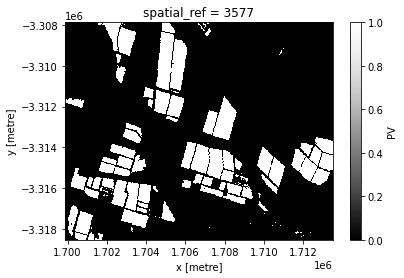

In [8]:
(land_std > 20).plot(cmap='Greys_r')

## Using masks within XArray Datasets

XArray contains a function `.where` to apply binary masks to all the `DataArrays` in a `Dataset`. Here you use it filter your data with the cropping land mask first and then with an unmixing error threshold. As you can see you can chain as many operations as you want to a `Dataset`. The expression evaluates from left to right so the order of the operations affect the result and also the performance (time) of the operation.

You create this expression which filters your data twice and then plot the result specifying a colormap and minimum and maximum values for the colour scale.

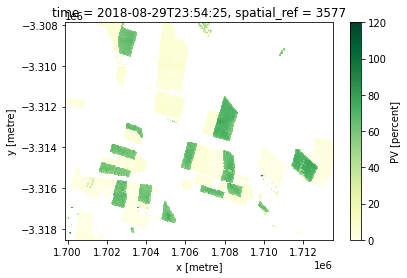

In [9]:
mean_error = fc_propA.UE.mean(dim='time')

fc_propA.PV.where(land_std>20).where(mean_error<=20.0).isel(time=3).plot(cmap='YlGn', vmax=120, vmin=0)

### Interactive plots

You have seen in a blog post someone demonstrating a very cool Jupyter notebook functionality to create dynamic visualisations. Once you have located you decide to create an interactive time lapse version of the last cropping season for the first property. 

In [10]:
from ipywidgets import interactive

def plot_field(t):
    fc_propA.PV.where(land_std>20).where(mean_error<=20.0).isel(time=t).plot(cmap='YlGn', vmax=120, vmin=0)

interactive_plot = interactive(plot_field, t=(0, fc_propA.time.shape[0]-1))
output = interactive_plot.children[-1]
output.layout.height = '350px'

interactive_plot

interactive(children=(IntSlider(value=7, description='t', max=14), Output(layout=Layout(height='350px'))), _do…

### Temporal plots

Finally you want to visualise the temporal evolution of the cropping lands over the last year. You are quite surprised to realise that there are what it looks like two seasons, first in spring and the second one more productive in autum.

In [ ]:
plt.figure(figsize=(10,2))
fc_propA.PV.where(land_std>20).where(mean_error<=20.0).mean(dim=['x','y']).plot()

### Property B

Now that you know how to perform the analysis you repeat the process for the second farm.

In [ ]:
query = {'lat': (-29.30, -29.38),
         'lon': (149.65, 149.78),
         'time':('2018-06-01', '2019-06-01')}

fc_propB = dc_moree.load(product='ls8_fc_albers', **query)

print(fc_propB.time.shape)

# Cloud filtering functionality for FC is currently being developed so we manually filter cloudly images
fc_propB = fc_propB.isel(time=[0,2,4,5,6,7,9,10,11,12,13,16,19,20,22])

fc_propB

### Detecting cropping lands

In [ ]:
land_std = fc_propB.PV.std(dim='time')
print("Shape:",land_std.shape)
print("Min: {:02f}, Max: {:02f}, Mean {:02f}".format(np.nanmin(land_std), np.nanmax(land_std), np.nanmean(land_std)))### Now we load and look at some data

(land_std > 20).plot(cmap='Greys_r')

### Plotting fractions

In [ ]:
plot_fractions(fc_propB, 0)

### Interactive year time-lapse

In [ ]:
def plot_field(t):
    fc_propB.PV.where(land_std>20).isel(time=t).plot(cmap='YlGn', vmax=120, vmin=0)

interactive_plot = interactive(plot_field, t=(0, fc_propB.time.shape[0]-1))

output = interactive_plot.children[-1]
output.layout.height = '350px'

interactive_plot

### Year vegetation evolution

In [ ]:
plt.figure(figsize=(10,2))
fc_propB.PV.where(land_std>20).mean(dim=['x','y']).plot()

### Exercise

You are very curious about this double cycle and decide to explore if this is the case in other cotton growing areas in Australia. Can you locate a cotton farming area near Toowoomba (QLD) and create a similar plot for the last year?